In [1]:
from collections import defaultdict
import cv2
from fastai.vision.all import *
from PIL import ImageFile, Image, ImageDraw
ImageFile.LOAD_TRUNCATED_IMAGES = True
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap

### Load images and labels

In [2]:
with open('img2msk.pkl', 'rb') as f:
    img2msk = pickle.load(f)
    # Even having read the paper, I'm confused about the relationship between an image, a mask, a label, and a heatmap.
    # Could you please explain?

with open('holdout.pkl', 'rb') as f:
    holdout_img2msk = pickle.load(f)    

In [3]:
with open('gt_lbls.txt', 'r') as filehandle:
    gt_lbls = json.load(filehandle)
    
with open('holdout_lbls.txt', 'r') as filehandle:
    holdout_lbls = json.load(filehandle) 

In [11]:
print(len(img2msk)) # This represents the number of images (slides) in the training set, is that right?

print(len(img2msk[0])) # So for each slide, there is an image at index 0, and something else at index 1. What is at index 1? Is it a mask?

print(img2msk[0][1]) # Why is a mask represented like this (as a 3D array)?

680
2
[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.00292541 0.00442662 0.00654152 ... 0.         0.         0.        ]
  [0.00393257 0.

In [8]:
gt_lbls[0]['Label'] # This represents the ground-truth annotations the centres of the cells in a slide. 
# I'm assuming that in this case, some annotators identified more/less cells than others?
# (because there are 27 cells and 27 is not divisible by 4, meaning that they couldn't have all identified the same number of cells)

{'Macrophage': [{'geometry': {'x': 969, 'y': 891}},
  {'geometry': {'x': 838, 'y': 470}},
  {'geometry': {'x': 769, 'y': 351}},
  {'geometry': {'x': 744, 'y': 52}},
  {'geometry': {'x': 380, 'y': 193}},
  {'geometry': {'x': 257, 'y': 384}},
  {'geometry': {'x': 247, 'y': 894}},
  {'geometry': {'x': 138, 'y': 732}},
  {'geometry': {'x': 134, 'y': 199}},
  {'geometry': {'x': 74, 'y': 54}}],
 'Monocyte': [{'geometry': {'x': 723, 'y': 950}},
  {'geometry': {'x': 416, 'y': 697}},
  {'geometry': {'x': 377, 'y': 394}},
  {'geometry': {'x': 226, 'y': 596}}],
 'Neutrophil': [{'geometry': {'x': 857, 'y': 741}},
  {'geometry': {'x': 544, 'y': 383}},
  {'geometry': {'x': 164, 'y': 897}}],
 'Eosinophil': [{'geometry': {'x': 595, 'y': 449}}],
 'Lymphocyte': [{'geometry': {'x': 687, 'y': 388}},
  {'geometry': {'x': 135, 'y': 34}}],
 'Unknown cell': [{'geometry': {'x': 915, 'y': 261}},
  {'geometry': {'x': 903, 'y': 453}},
  {'geometry': {'x': 874, 'y': 206}},
  {'geometry': {'x': 861, 'y': 556}},
  {

In [12]:
out_path = Path('/Users/shayanrasaratnam/Documents/DCNet-main')  # path provided but no image is saved.
out_path.mkdir(parents=True, exist_ok=True)

In [13]:
Eosinophil      = (1, 0.6,   0)  # orange
Lymphocyte      = (0,   1,   0)  # green
MacroMono       = (1,   0,   0)  # red 
Neutrophil      = (0,   1,   1)  # cyan

TILE_SZ = 1024

# I'm assuming the annotators identified them as either a Macrophage OR a Monocyte
# In which case why are they grouped together over here?
class_map = {
    # LBName: (idx, display, color, radius)  # average radius scenario 
    'Eosinophil': (0, 'Eosinophil', Eosinophil, 61/TILE_SZ),  
    'Lymphocyte': (1, 'Lymphocyte', Lymphocyte, 30/TILE_SZ),  
    'Macrophage': (2, 'Macro+Mono', MacroMono,  76/TILE_SZ), 
    'Monocyte':   (2, 'Macro+Mono', MacroMono,  76/TILE_SZ), 
    'Neutrophil': (3, 'Neutrophil', Neutrophil, 52/TILE_SZ)   
}

classes = sorted(set(class_map.values()))
classes

[(0, 'Eosinophil', (1, 0.6, 0), 0.0595703125),
 (1, 'Lymphocyte', (0, 1, 0), 0.029296875),
 (2, 'Macro+Mono', (1, 0, 0), 0.07421875),
 (3, 'Neutrophil', (0, 1, 1), 0.05078125)]

In [14]:
# taken from https://github.com/xingyizhou/CenterNet/blob/819e0d0dde02f7b8cb0644987a8d3a370aa8206a/src/lib/utils/image.py

# Could you explain how a "2D Gaussian kernel" works in simple terms?
# This code is difficult to read, and I don't have a maths background.
def gaussian2D(shape, sigma=1):     # sigma = 1 means 1 standard deviation
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m:m+1,-n:n+1]  # constructing an open grid (ogrid) of size [-m x m+1] x [-n x n+1] to create a mask

    h = np.exp(-(x * x + y * y) / (2 * sigma * sigma))  # https://en.wikipedia.org/wiki/Gaussian_function (see 2D gaussian)
    h[h < np.finfo(h.dtype).eps * h.max()] = 0          # see https://numpy.org/doc/stable/reference/generated/numpy.finfo.html for.eps 
    return h

# Same here, could you explain what this function does?
def draw_umich_gaussian(heatmap, center, radius, k=1):
    diameter = 2 * radius + 1
    gaussian = gaussian2D((diameter, diameter), sigma=diameter / 6)  # see CornerNet: Detecting Objects as Paired Keypoints for sigma

    x, y = int(center[0]), int(center[1])

    height, width = heatmap.shape[:2]

    left, right = min(x, radius), min(width - x, radius + 1)
    top, bottom = min(y, radius), min(height - y, radius + 1)

    masked_heatmap  = heatmap[      y - top:     y + bottom,      x - left:     x + right]  # capped mask size (diameter x diameter)
    masked_gaussian = gaussian[radius - top:radius + bottom, radius - left:radius + right]   
    if min(masked_gaussian.shape) > 0 and min(masked_heatmap.shape) > 0: # TODO debug
        np.maximum(masked_heatmap, masked_gaussian * k, out=masked_heatmap)
    return heatmap

In [15]:
# What's the purpose of this function?
# It's called in "parse_pairs", but "parse_pairs" is not called anywhere?
def centroid2mask(img, point2lbl, c=len(classes)):
    w,h = img.shape
    img_msk = np.zeros((c,w,h))
    
    for k,v in point2lbl.items():
        if k not in class_map: continue
        idx,label,color,radius = class_map[k]
        for pt in v:
            x,y = [p*w/TILE_SZ for p in pt]
            draw_umich_gaussian(img_msk[idx], (x,y), radius=int(radius*w))
    return img_msk

In [16]:
# What's the diference between a heatmap and a Tensor heatmap?
class TensorHeatMap(TensorMask):
    _show_args = {'interpolation': 'nearest'}

    def show(self, ctx=None, alpha=1.0, mask_alpha=1.0, **kwargs):
        for m, (_,_,c,_) in zip(self,classes):
            nodes = [0.0, 1.0]
            cs = [[0,0,0,0],c]
            cmap = LinearSegmentedColormap.from_list("cmap", list(zip(nodes, cs)))
            show_image(m, ctx=ctx, cmap=cmap, alpha=mask_alpha, **{**self._show_args, **kwargs})

In [17]:
patches = [mpatches.Patch(color=color, label=label) for idx,label,color,radius in classes]
def show_legend(): plt.legend(handles=patches, bbox_to_anchor=(1, 1), loc='upper left')

### Generate Masks for all rows

In [18]:
def parse_pairs(row_data, sz=256, img_dir=out_path, source_folder='images'):
    label = row_data['Label']
    img_url = row_data['Labeled Data']
    lbl_id = row_data['External ID'][:-4]
    img_path = out_path/source_folder/f'{lbl_id}.png'
    img_path.parent.mkdir(parents=True, exist_ok=True)
    if img_path.exists():
        img = PILImage.create(img_path)
    else:
        img = img_from_url(img_url)
        with open(img_path, 'wb') as f: img.save(f)
    
    img = img.resize((sz,sz))
    centroid2lbl = json2centroid(label)
    mask = centroid2mask(img, centroid2lbl)
    return img, mask

In [19]:
@patch
def affine_coord(x: TensorHeatMap, mat=None, coord_tfm=None, sz=None, mode='nearest',
                 pad_mode=PadMode.Reflection, align_corners=True):
    add_dim = (x.ndim==3)
    if add_dim: x = x[:,None]
    res = TensorImage.affine_coord(x.float(), mat, coord_tfm, sz, mode, pad_mode, align_corners)#.long() - We use gaussian kernels. Mask must be float
    if add_dim: res = res[:,0]
    return TensorHeatMap(res)

In [20]:
def get_x(idx): return PILImage(img2msk[idx][0])
def get_y(idx): return TensorHeatMap(img2msk[idx][1])

In [21]:
idxs = range(len(img2msk))   
splits = RandomSplitter(seed=42)(idxs)
dsets = Datasets(items=idxs, tfms=[[get_x, ToTensor, IntToFloatTensor], [get_y]], splits=splits)

In [22]:
splits

((#544) [296,288,204,416,319,39,215,145,551,407...],
 (#136) [302,185,12,530,606,115,290,315,78,396...])

In [23]:
bs = 2

In [24]:
batch_tfms = [*aug_transforms(max_zoom=1.0, max_warp=0, max_rotate=45, flip_vert=True), Normalize.from_stats(*imagenet_stats)]
dls = dsets.dataloaders(bs=bs, after_batch=batch_tfms)

In [25]:
xb,yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([2, 3, 256, 256]), torch.Size([2, 4, 256, 256]))

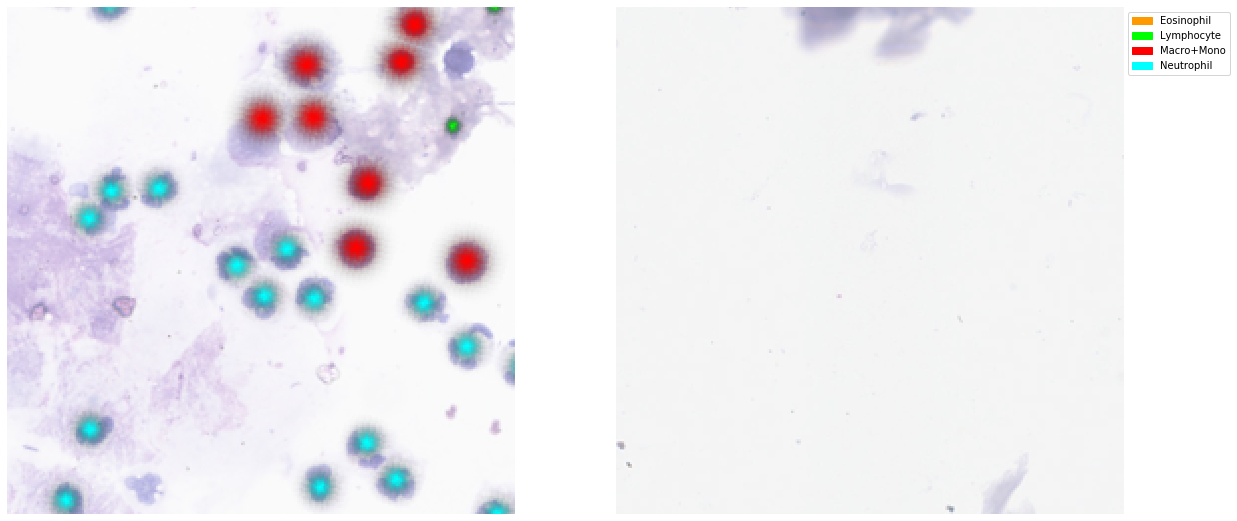

In [26]:
dls.show_batch(figsize=(20,10), alpha=0.5)
show_legend()

### Train Model

In [27]:
def acc_nuclei(input, target):
    mask = target > 0.1
    acc = (input[mask] > 0.1) == (target[mask] > 0.1)
    return acc.float().mean()

In [28]:
def _neg_loss(pred, gt, eps=1e-12):
    ''' Modified focal loss. Exactly the same as CornerNet.
      Runs faster and costs a little bit more memory
    Arguments:
      pred (batch x c x h x w)
      gt_regr (batch x c x h x w)
    '''
    pos_inds = gt.eq(1).float()
    neg_inds = gt.lt(1).float()

    neg_weights = torch.pow(1 - gt, 4)

    loss = 0

    pos_loss = torch.log(pred + eps) * torch.pow(1 - pred, 2) * pos_inds
    neg_loss = torch.log(1 - pred + eps) * torch.pow(pred, 2) * neg_weights * neg_inds

    num_pos  = pos_inds.float().sum()
    pos_loss = pos_loss.sum()
    neg_loss = neg_loss.sum()

    if num_pos == 0: 
        loss = loss - neg_loss
    else:
        loss = loss - (pos_loss + neg_loss) / num_pos
    return loss

class FocalLoss(nn.Module):
    '''nn.Module warpper for focal loss'''
    def __init__(self, loss=_neg_loss):
        super().__init__()
        self.neg_loss = loss

    def forward(self, out, target):
        
        bs,ch = target.shape[:2]
        sout = torch.sigmoid(out)
        loss1 = self.neg_loss(sout, target.data)
        loss1 = loss1.sum() / bs
        return loss1
    
    def activation(self, x): return torch.sigmoid(x)

In [29]:
dls.c = len(classes)
loss_func = FocalLoss()
learn = unet_learner(dls, resnet34, metrics=acc_nuclei, loss_func=loss_func, pretrained=True)

/Users/shayanrasaratnam/opt/anaconda3/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/Users/shayanrasaratnam/opt/anaconda3/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /Users/shayanrasaratnam/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [30]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [31]:
learn.freeze()
learn.loss_func = FocalLoss(F.mse_loss)
learn.fit(1, 1e-4, wd=1e-5)

epoch,train_loss,valid_loss,acc_nuclei,time
0,0.002883,0.002688,0.000000,24:40


In [34]:
learn.loss_func = FocalLoss()
learn.fit(4, 2e-4, wd=1e-5)

epoch,train_loss,valid_loss,acc_nuclei,time


OSError: [Errno 24] Too many open files

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(60, 5e-4, wd=1e-5)

In [ ]:
learn.fit_one_cycle(60, 5e-4, wd=1e-5)

learn.save('3g_latest_mean_IVTs')

In [ ]:
learn.load('3g_latest_mean_IVTs')

### Calculation of Average Precision

In [ ]:
def compute_ap(precision, recall):
    "Compute the average precision for `precision` and `recall` curve."
    recall = np.concatenate(([0.], list(recall), [1.]))
    precision = np.concatenate(([0.], list(precision), [0.]))
    for i in range(len(precision) - 1, 0, -1):
        precision[i - 1] = np.maximum(precision[i - 1], precision[i])
    idx = np.where(recall[1:] != recall[:-1])[0]
    ap = np.sum((recall[idx + 1] - recall[idx]) * precision[idx + 1])
    return ap

In [ ]:
def euclidean_dist(pt1, pt2):
    (xA,yA), (xB,yB) = pt1, pt2
    return ((xB-xA)**2 + (yB-yA)**2)**0.5

In [ ]:
def calc_class_ap(lbls, preds, min_area=4, iou_thresh=0.1, score_thresh=0.3):
    metrics = {}
    for idx,lbl,color,radius in classes:
        metrics[lbl] = [],[],[],[]
        
    for lbl,pred in zip(lbls,preds): # iterate through labels and predictions
        pred_points, lbl_points = extract_predictions(lbl, pred, score_thresh)
        
        for idx,cls,color,radius in classes: # calculate ap per class
            tps, fps, scores, n_gts = metrics[cls]
            
            ppoints = [pp for pp in pred_points if pp[0] == idx]
            ppoints = list(sorted(ppoints, key=lambda x: pred[x], reverse=True)) # sort by scores
            lpoints = [lb for lb in lbl_points if lb[0] == idx]

            pdists = []
            pscores = []
            matched = set()
            for ppoint in ppoints:
                all_dists = [(euclidean_dist(lpoint[1:], ppoint[1:]), lpoint) for lpoint in lpoints if lpoint not in matched]
                if len(all_dists) == 0:
                    pdists.append(1e10)
                else:
                    pdist, lpoint = min(all_dists)
                    matched.add(lpoint) # Found match. Remove label so it can't be matched again
                    pdists.append(pdist)
                pscores.append(pred[ppoint])
                
            w,h = lbl.shape[-2:]
            max_dist = radius * w * iou_thresh
            
            tp = (np.array(pdists) < max_dist)
            fp = ~tp

            n_gts.append(len(lpoints))
            tps.extend(tp.astype(np.uint8).tolist())
            fps.extend(fp.astype(np.uint8).tolist())
            scores.extend(pscores)
        
    aps = []
    for idx,cls,color,radius in classes:
        tps, fps, scores, n_gts = metrics[cls]
        res = sorted(zip(scores, tps, fps), key=lambda x: x[0], reverse=True)
        res = np.array(res)
        if len(res) == 0: res = np.zeros((1, 3))
        tp = res[:,1].cumsum(0)
        fp = res[:,2].cumsum(0)
        precision = tp / (tp + fp + 1e-8)
        recall = tp / (sum(n_gts) + 1e-8)
        
        aps.append({ 
            'class': cls, 
            'ap': round(compute_ap(precision, recall), 4), 
            'tp': int(tp[-1]), 
            'fp': int(fp[-1]), 
            'gt': sum(n_gts)
        })
        
    aps.append({
        'class': 'all',
        'ap': np.mean([x['ap'] for x in aps]),
        'tp': sum([x['tp'] for x in aps]),
        'fp': sum([x['fp'] for x in aps]),
        'gt': sum([x['gt'] for x in aps]),
    })
    return aps

In [ ]:
thresh = []
for iou_thresh in [0.1, 0.25, 0.5]:
    aps = []
    for score_thresh in [0.05, 0.1, 0.2, 0.4]:
        for min_area in [2,3,4]:
            ccap = calc_class_ap(lbls,preds, score_thresh=score_thresh, min_area=min_area, iou_thresh=iou_thresh)
            aps.append((ccap[-1]['ap'], score_thresh, min_area))
    print(iou_thresh, max(aps))
    thresh.append((iou_thresh,) + max(aps)[1:])

### Visualize Results

In [ ]:
class TensorMultiPoint(TensorBase):
    _show_args = dict(s=100, marker='.')

    @classmethod
    def create(cls, t, img_size=None)->None:
        "Convert an array or a list of points `t` to a `Tensor`"
        return cls(tensor(t).float(), img_size=img_size)

    def show(self, ctx=None, cmap=None, **kwargs):
        if 'figsize' in kwargs: del kwargs['figsize']
        for (cls_idx,_,color,_) in classes:
            pts = np.array([(y,x) for idx,x,y in self if idx==cls_idx])
            if len(pts) == 0: continue
            ctx.scatter(pts[:, 0], pts[:, 1], color=color, **{**self._show_args, **kwargs})
        return ctx

In [ ]:
def max_px(box, targ):
    m = np.zeros_like(targ)
    y,x,h,w = box
    m[:, x:x+w,y:y+h] = 1
    ind = np.unravel_index(np.argmax(targ*m, axis=None), targ.shape)
    return ind

In [ ]:
def extract_predictions(lbl, pred, score_thresh=0.1):
    pscore = (pred > score_thresh).astype(np.uint8)
    contours,hierarchy = cv2.findContours(pscore.max(0).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    pboxes = [cv2.boundingRect(cnt) for cnt in contours if cv2.contourArea(cnt) >= min_area]
    pred_points = [max_px(pbox, pred) for pbox in pboxes]
    
    lbl_points = list(zip(*(lbl==1.0).nonzero()))
    
    return pred_points, lbl_points

In [ ]:
inps,preds,lbls = learn.get_preds(with_input=True)
preds = preds.detach().cpu().numpy()
lbls = lbls.detach().cpu().numpy()
out = dls.decode_batch((inps, lbls))

In [ ]:
min_area = 4
idx = 0  # dls.decode_batch(max_n=9), so valid input for n is 0 to 8
inp, _ = out[idx]
pred, lbl = preds[idx], lbls[idx]
pred_points, lbl_points = extract_predictions(lbl, pred, score_thresh=0.1)

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(14,14))

ax[0].set_title('Target')
ctx = inp.show(ax[0])
TensorMultiPoint(lbl_points).show(ctx=ctx)  

ax[1].set_title('Prediction')
ctx = inp.show(ax[1])
TensorMultiPoint(pred_points).show(ctx=ctx)   

show_legend()

### Evaluation on Holdout Dataset

In [ ]:
def get_ho_x(idx): return PILImage(holdout_img2msk[idx][0])
def get_ho_y(idx): return TensorHeatMap(holdout_img2msk[idx][1])

In [ ]:
def classes2name(points):
    res = [0] * len(classes)
    for i in points:
        res[i[0]] += 1
    return res

In [ ]:
ho_idxs = range(len(holdout_lbls))   
ho_dsets = Datasets(items=ho_idxs, tfms=[[get_ho_x, ToTensor, IntToFloatTensor], [get_ho_y]])
batch_tfms = [Normalize.from_stats(*imagenet_stats)]
ho_dls = ho_dsets.dataloaders(bs=bs, after_batch=batch_tfms)

In [ ]:
inps,preds,lbls = learn.get_preds(dl=ho_dls, with_input=True)
preds = preds.detach().cpu().numpy()
lbls = lbls.detach().cpu().numpy()
ho_out = ho_dls.decode_batch((inps, lbls), max_n=len(holdout_lbls))  

In [ ]:
import time
start = time.time()

ho_results = []   
for idx in range(len(holdout_lbls[:])):
    inp, _ = ho_out[idx]
    pred, lbl = preds[idx], lbls[idx]
    pred_points, lbl_points = extract_predictions(lbl, pred, score_thresh=0.1)
    
    fig, ax = plt.subplots(ncols=2, figsize=(14,14))  # warning: if the figsize set too big, some points will missing from display and count.

    target = classes2name(lbl_points)
    prediction = classes2name(pred_points)
    
    fname = holdout_lbls[idx]['External ID']
    # for creating dataframes for the holdout dataset
    row = target + prediction
    row.append(fname)
    ho_results.append(row)
    
    # for images comparison
    
    t_title = f'{fname} Target: {target}'
    ax[0].set_title(t_title)
    ctx = inp.show(ax[0])
    TensorMultiPoint(lbl_points).show(ctx=ctx)  

    p_title = f'Prediction: {prediction}'
    ax[1].set_title(p_title)
    ctx = inp.show(ax[1])
    TensorMultiPoint(pred_points).show(ctx=ctx)   

    show_legend()
     
end = time.time()
print(f'time to predict {idx+1} tiles: {(end - start)} minutes.') 

In [ ]:
df_ho= pd.DataFrame(ho_results, columns=['T_Eos', 'T_Lym', 'T_M+M', 'T_Neu', 'P_Eos', 'P_Lym', 'P_M+M', 'P_Neu', 'filename'])

In [ ]:
df_hout = df_ho.set_index('filename')
df_hout.sort_index(ascending=True, inplace=True)

In [ ]:
df_hout['D_Eos'] = df_hout['T_Eos'] - df_hout['P_Eos']
df_hout['D_Lym'] = df_hout['T_Lym'] - df_hout['P_Lym']
df_hout['D_M+M'] = df_hout['T_M+M'] - df_hout['P_M+M']
df_hout['D_Neu'] = df_hout['T_Neu'] - df_hout['P_Neu']
df_hout.head()

### Model Architecture for Schematic Diagram

In [ ]:
learn.summary()